# conda environments:
#
base                  *  /Users/aadam/anaconda3


Note: you may need to restart the kernel to use updated packages.


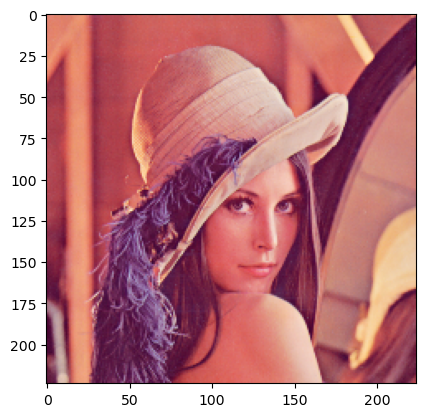

In [4]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("lena_color.png") #photo located in same folder as code
img = cv2.resize(img, (224,224)) 

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #cv2 opens files in BGR format by default, so we convert it to RGB

plt.imshow(img)
plt.show() 


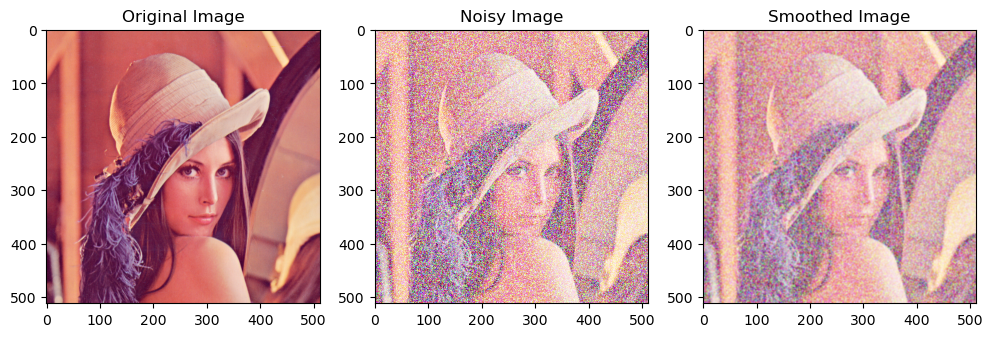

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, sigma=5):
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch)).astype('uint8')
    noisy = cv2.add(image, gauss)
    return noisy

# Apply a Gaussian filter to the image
def apply_gaussian_filter(image, kernel_size=(5, 5), sigmaX=0):
    return cv2.GaussianBlur(image, kernel_size, sigmaX)

# Load the image
img = cv2.imread("lena_color.png") # Ensure the image is in the same folder as the script
# img = cv2.resize(img, (224, 224)) uncomment to swap to 224x224

# Convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Add Gaussian noise
noisy_img = add_gaussian_noise(img)

# Apply Gaussian filter (smoothing)
smoothed_img = apply_gaussian_filter(noisy_img)

# Display the original, noisy, and smoothed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img)
plt.title('Noisy Image')

plt.subplot(1, 3, 3)
plt.imshow(smoothed_img)
plt.title('Smoothed Image')

plt.show()


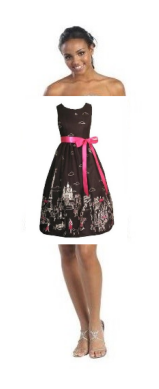

'dressed_model_corrected.jpeg'

In [43]:
def crop_white_background(image):
    """
    Crops the white background from an image.
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image to get the foreground (non-white) pixels
    _, thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour assuming it's the main object (dress)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image using the dimensions of the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    # Create a mask for the cropped area
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

    # Bitwise-and the mask with the input image
    foreground = cv2.bitwise_and(image, image, mask=mask[y:y+h, x:x+w])

    return foreground, (x, y, w, h)

def place_dress_on_model(model, dress, dress_bbox):
    """
    Places the dress image onto the model image at the location specified by dress_bbox.
    """
    x, y, w, h = dress_bbox

    # Resize the dress to fit the bounding box
    dress_resized = cv2.resize(dress, (w, h))

    # Create a mask for the resized dress
    dress_gray = cv2.cvtColor(dress_resized, cv2.COLOR_BGR2GRAY)
    _, dress_mask = cv2.threshold(dress_gray, 1, 255, cv2.THRESH_BINARY)

    # Place the dress on the model
    model_with_dress = model.copy()
    dress_area = model_with_dress[y:y+h, x:x+w]
    dress_area[np.where(dress_mask)] = dress_resized[np.where(dress_mask)]
    model_with_dress[y:y+h, x:x+w] = dress_area

    return model_with_dress

# Load the images
dress_img = cv2.imread('dress1.jpeg')
model_img = cv2.imread('model1.jpeg')

# Crop the white backgrounds from the images
dress_foreground, dress_bbox = crop_white_background(dress_img)
model_foreground, _ = crop_white_background(model_img)

# Determine the bounding box of the grey dress on the model
# Here we assume that the dress to be replaced is centrally located and has the largest grey area
grey_lower = np.array([0, 0, 50], dtype="uint8")
grey_upper = np.array([220, 30, 200], dtype="uint8")
grey_mask = cv2.inRange(cv2.cvtColor(model_foreground, cv2.COLOR_BGR2HSV), grey_lower, grey_upper)
contours, _ = cv2.findContours(grey_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
grey_dress_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(grey_dress_contour)

# The dress_bbox has the dimensions of the cropped dress, we need to resize and place it over the grey area
model_with_dress = place_dress_on_model(model_img, dress_foreground, (x, y, w, h))

# Save and display the final image
output_path = 'dressed_model_corrected.jpeg'
cv2.imwrite(output_path, model_with_dress)

plt.imshow(cv2.cvtColor(model_with_dress, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

output_path


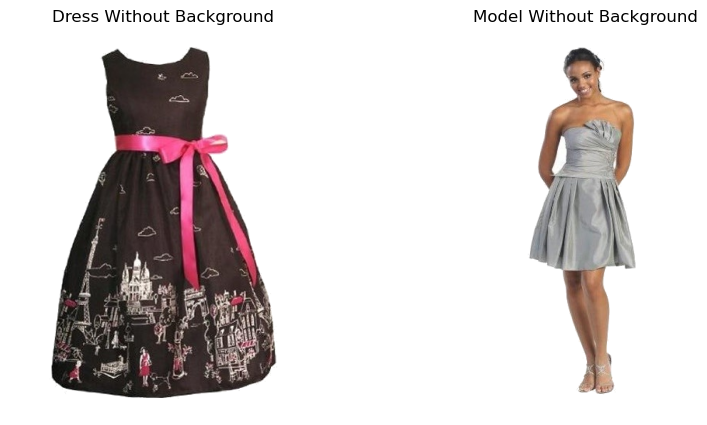

('dress_no_bg.png', 'model_no_bg.png')

In [48]:
def remove_white_background(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply threshold to get mask of non-white areas
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours from the threshold image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)  # Create a mask of zeros the same size as the grayscale image
    
    # Fill the detected contours with white (255) on the mask
    for cnt in contours:
        cv2.drawContours(mask, [cnt], 0, 255, -1)
    
    # Bitwise the image with the mask
    image[mask == 0] = [255, 255, 255]  # Set the background to white

    return image

# Load the images
dress_img = cv2.imread('dress1.jpeg')
model_img = cv2.imread('model1.jpeg')

# Remove the white backgrounds
dress_no_bg = remove_white_background(dress_img)
model_no_bg = remove_white_background(model_img)

# Save the images without white background
dress_no_bg_path = 'dress_no_bg.png'
model_no_bg_path = 'model_no_bg.png'
cv2.imwrite(dress_no_bg_path, dress_no_bg)
cv2.imwrite(model_no_bg_path, model_no_bg)

# Display the images without white background
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(dress_no_bg, cv2.COLOR_BGR2RGB))
plt.title('Dress Without Background')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(model_no_bg, cv2.COLOR_BGR2RGB))
plt.title('Model Without Background')
plt.axis('off')

plt.show()

(dress_no_bg_path, model_no_bg_path)
